# Style Transcoders

In [1]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import npy_classical_path, npy_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import tune_hyperparameters, load_optimal_params

2023-11-27 00:33:52.400361: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 00:33:52.400415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 00:33:52.400456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 00:33:52.410061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Loading

### Load Audio & Extract Features

In [3]:
n_samples = 5000
n_samples = min(n_samples, len(os.listdir(npy_classical_path)), len(os.listdir(npy_jazz_path)))
print(f"{n_samples = }")

X_c_raw = load_data(npy_classical_path, n_samples=n_samples)
X_j_raw = load_data(npy_jazz_path, n_samples=n_samples)

print(f"{X_c_raw.shape = }")
print(f"{X_j_raw.shape = }")

n_samples = 5000
99 %
99 %
X_c_raw.shape = (5000, 67, 128, 1)
X_j_raw.shape = (5000, 67, 128, 1)


### Train - Validation - Test Split

In [4]:
# Fraction of data to keep apart for validation
test_size = round(0.1 * n_samples)
val_size = test_size
# Perform splits
X_c_raw_train, X_c_raw_test = train_test_split(X_c_raw, test_size=test_size)
X_c_raw_train, X_c_raw_val = train_test_split(X_c_raw_train, test_size=val_size)
X_j_raw_train, X_j_raw_test = train_test_split(X_j_raw, test_size=test_size)
X_j_raw_train, X_j_raw_val = train_test_split(X_j_raw_train, test_size=val_size)
# Verify split shapes
print(f"{X_c_raw_train.shape = }")
print(f"{X_c_raw_test.shape = }")
print(f"{X_c_raw_val.shape = }")
print(f"{X_j_raw_train.shape = }")
print(f"{X_j_raw_test.shape = }")
print(f"{X_j_raw_val.shape = }")

X_c_raw_train.shape = (4000, 67, 128, 1)
X_c_raw_test.shape = (500, 67, 128, 1)
X_c_raw_val.shape = (500, 67, 128, 1)
X_j_raw_train.shape = (4000, 67, 128, 1)
X_j_raw_test.shape = (500, 67, 128, 1)
X_j_raw_val.shape = (500, 67, 128, 1)


### Normalize Features

In [5]:
# Perform normalization
X_c_train, X_c_val, X_c_test = normalize_features(X_c_raw_train, X_raw_val=X_c_raw_val, X_raw_test=X_c_raw_test, name="classical")
X_j_train, X_j_val, X_j_test = normalize_features(X_j_raw_train, X_raw_val=X_j_raw_val, X_raw_test=X_j_raw_test, name="jazz")

print(f"{X_c_train.shape }")
print(f"{X_c_val.shape }")
print(f"{X_c_test.shape }")
print(f"{X_j_train.shape }")
print(f"{X_j_val.shape }")
print(f"{X_j_test.shape }")

(4000, 67, 128, 1)
(500, 67, 128, 1)
(500, 67, 128, 1)
(4000, 67, 128, 1)
(500, 67, 128, 1)
(500, 67, 128, 1)


In [6]:
input_shape = X_c_train.shape[1:]

print(f"{input_shape = }")

input_shape = (67, 128, 1)


## Style Transfer Models

### Test Script

In [7]:
# Test transcoder
def test_transcoder(transcoder, X_test=X_c_test, Y_test=X_j_test, plot_transforms=True):
    # Random picks
    print("Picking samples")
    X = np.expand_dims(X_test[np.random.choice(len(X_test))], axis=0)
    Y = np.expand_dims(Y_test[np.random.choice(len(Y_test))], axis=0)
    print(f"{X.shape = }")
    print(f"{Y.shape = }")
    
    # Transcode
    print("Performing transcode")
    Y_fake = transcoder.transcode(X, XtoY=True)
    X_fake = transcoder.transcode(Y, XtoY=False)
    
    # Reconstruct raw spectra
    print("Denormalizing")
    X_raw = denormalize_features(X, name="classical")
    X_raw_fake = denormalize_features(X_fake, name="classical")
    Y_raw = denormalize_features(Y, name="jazz")
    Y_raw_fake = denormalize_features(Y_fake, name="jazz")
    
    # Plot raw spectra
    if plot_transforms:
        print("Plotting transforms")
        fig, ax = plot_spectral_feature(X_raw)
        ax.set_title("Classical Spectrum")
        fig, ax = plot_spectral_feature(Y_raw)
        ax.set_title("Jazz Spectrum")
        fig, ax = plot_spectral_feature(X_raw_fake)
        ax.set_title(r"Jazz $\rightarrow$ Classical Spectrum")
        fig, ax = plot_spectral_feature(Y_raw_fake)
        ax.set_title(r"Classical $\rightarrow$ Jazz Spectrum")
        plt.show()
    
    # Reconstruct audio
    print("Reconstructing audio")
    sX = np.squeeze(compute_imels(np.squeeze(X_raw)))
    sX_fake = np.squeeze(compute_imels(np.squeeze(X_raw_fake)))
    sY = np.squeeze(compute_imels(np.squeeze(Y_raw)))
    sY_fake = np.squeeze(compute_imels(np.squeeze(Y_raw_fake)))
    
    # Play audio
    print("Classical audio")
    player = play_audio(sX)
    print("Jazz audio")
    player = play_audio(sY)
    print("Jazz to Classical audio")
    player = play_audio(sX_fake)
    print("Classical to Jazz audio")
    player = play_audio(sY_fake)    

### Convolutional Style Transfer

In [8]:
from models.transcoders import Conv2DTranscoder

In [9]:
default_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "h_reg": 1e-1,
    "kl_reg": 0.,
}
results_path = os.path.join("./results/ConvolutionalTranscoder")
os.makedirs(results_path, exist_ok=True)

In [10]:
# Construct model
transcoder = Conv2DTranscoder(**default_params)
transcoder.compile(optimizer="adam")

2023-11-27 00:28:23.422537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 00:28:23.433113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 00:28:23.435926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [25]:
# Train model
loss_key = "val_r_loss"
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = transcoder.fit(X_c_train, X_j_train, epochs=250, shuffle=True, callbacks=[earlystopping], validation_data=(X_c_val, X_j_val), verbose=1)

Epoch 1/250
125/125 [==============================] - 10s 28ms/step - loss: 0.1827 - r_loss: 0.1819 - h_loss: 0.0083 - kl_loss: 0.0012 - val_loss: 0.1679 - val_r_loss: 0.1669 - val_h_loss: 0.0100 - val_kl_loss: 0.0013
Epoch 2/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1572 - r_loss: 0.1555 - h_loss: 0.0172 - kl_loss: 0.0035 - val_loss: 0.1423 - val_r_loss: 0.1396 - val_h_loss: 0.0270 - val_kl_loss: 0.0088
Epoch 3/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1357 - r_loss: 0.1332 - h_loss: 0.0241 - kl_loss: 0.0079 - val_loss: 0.1291 - val_r_loss: 0.1268 - val_h_loss: 0.0227 - val_kl_loss: 0.0056
Epoch 4/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1245 - r_loss: 0.1224 - h_loss: 0.0210 - kl_loss: 0.0053 - val_loss: 0.1185 - val_r_loss: 0.1165 - val_h_loss: 0.0200 - val_kl_loss: 0.0036
Epoch 5/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1136 - r_loss: 0.1115 - h_loss: 0.0203 - kl_loss:

125/125 [==============================] - 3s 20ms/step - loss: 0.0723 - r_loss: 0.0711 - h_loss: 0.0118 - kl_loss: 3.1887e-04 - val_loss: 0.0728 - val_r_loss: 0.0716 - val_h_loss: 0.0114 - val_kl_loss: 2.3280e-04
Epoch 74/250
125/125 [==============================] - 3s 21ms/step - loss: 0.0724 - r_loss: 0.0712 - h_loss: 0.0120 - kl_loss: 3.0745e-04 - val_loss: 0.0720 - val_r_loss: 0.0709 - val_h_loss: 0.0115 - val_kl_loss: 2.5518e-04
Epoch 75/250
125/125 [==============================] - 3s 21ms/step - loss: 0.0723 - r_loss: 0.0712 - h_loss: 0.0117 - kl_loss: 2.9236e-04 - val_loss: 0.0732 - val_r_loss: 0.0720 - val_h_loss: 0.0124 - val_kl_loss: 2.6907e-04
Epoch 76/250
125/125 [==============================] - 3s 20ms/step - loss: 0.0722 - r_loss: 0.0711 - h_loss: 0.0118 - kl_loss: 2.9292e-04 - val_loss: 0.0718 - val_r_loss: 0.0707 - val_h_loss: 0.0115 - val_kl_loss: 2.3428e-04
Epoch 77/250
125/125 [==============================] - 3s 20ms/step - loss: 0.0720 - r_loss: 0.0708 - h_

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


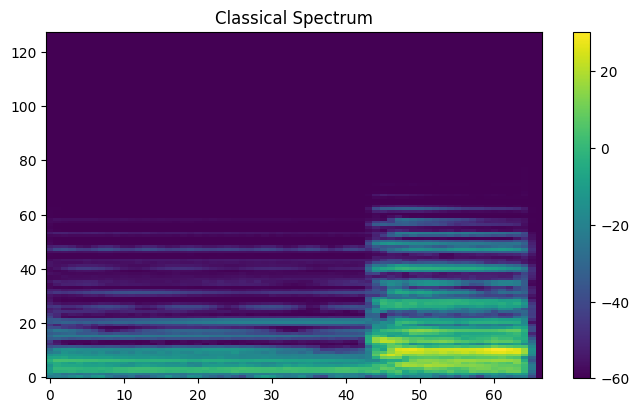

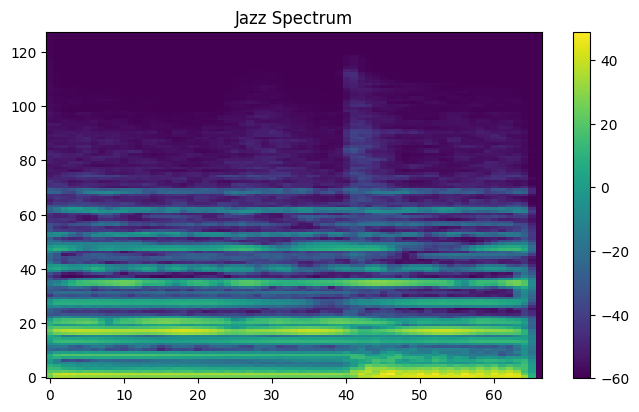

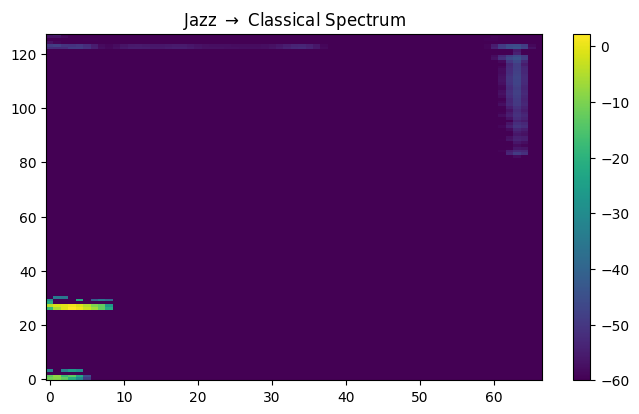

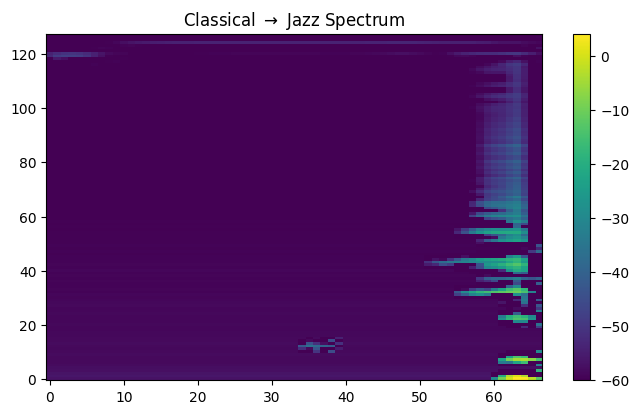

Reconstructing audio
Classical audio


Jazz audio


Jazz to Classical audio


Classical to Jazz audio


In [13]:
# Test model
test_transcoder(transcoder)

In [30]:
# Save model
transcoder.save_weights(os.path.join(results_path, "model"))

In [12]:
# Load model
transcoder = Conv2DTranscoder(**default_params)
transcoder.load_weights(os.path.join(results_path, "model"))

### Variational Style Transfer

In [33]:
from models.transcoders import VariationalTranscoder

In [60]:
default_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "h_reg": 1e-5,
    "kl_reg": 1e-3,
}
results_path = os.path.join("./results/VariationalTranscoder")
os.makedirs(results_path, exist_ok=True)

In [61]:
# Construct model
transcoder = VariationalTranscoder(**default_params)
transcoder.compile(optimizer="adam")

In [62]:
# Train model
loss_key = "val_r_loss"
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = transcoder.fit(X_c_train, X_j_train, epochs=250, callbacks=[earlystopping], shuffle=True, validation_data=(X_c_val, X_j_val), verbose=1)

Epoch 1/250
125/125 [==============================] - 11s 35ms/step - loss: 0.2076 - r_loss: 0.2076 - h_loss: 0.0464 - kl_loss: 0.0097 - val_loss: 0.2054 - val_r_loss: 0.2054 - val_h_loss: 0.0403 - val_kl_loss: 0.0290
Epoch 2/250
125/125 [==============================] - 3s 26ms/step - loss: 0.2052 - r_loss: 0.2052 - h_loss: 0.0501 - kl_loss: 0.0078 - val_loss: 0.2054 - val_r_loss: 0.2054 - val_h_loss: 0.0570 - val_kl_loss: 0.0033
Epoch 3/250
125/125 [==============================] - 3s 26ms/step - loss: 0.2051 - r_loss: 0.2051 - h_loss: 0.1048 - kl_loss: 0.0130 - val_loss: 0.2052 - val_r_loss: 0.2051 - val_h_loss: 0.2325 - val_kl_loss: 0.0794
Epoch 4/250
125/125 [==============================] - 3s 26ms/step - loss: 0.1895 - r_loss: 0.1890 - h_loss: 0.5609 - kl_loss: 0.5395 - val_loss: 0.1792 - val_r_loss: 0.1786 - val_h_loss: 0.6185 - val_kl_loss: 0.6727
Epoch 5/250
125/125 [==============================] - 3s 26ms/step - loss: 0.1718 - r_loss: 0.1707 - h_loss: 0.7409 - kl_loss:

125/125 [==============================] - 3s 26ms/step - loss: 0.0888 - r_loss: 0.0833 - h_loss: 1.1847 - kl_loss: 5.5130 - val_loss: 0.0886 - val_r_loss: 0.0834 - val_h_loss: 1.1544 - val_kl_loss: 5.1790
Epoch 76/250
125/125 [==============================] - 3s 27ms/step - loss: 0.0889 - r_loss: 0.0834 - h_loss: 1.1899 - kl_loss: 5.5376 - val_loss: 0.0884 - val_r_loss: 0.0831 - val_h_loss: 1.1997 - val_kl_loss: 5.3578
Epoch 77/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0886 - r_loss: 0.0831 - h_loss: 1.1938 - kl_loss: 5.4899 - val_loss: 0.0884 - val_r_loss: 0.0830 - val_h_loss: 1.1817 - val_kl_loss: 5.3753
Epoch 78/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0885 - r_loss: 0.0830 - h_loss: 1.1880 - kl_loss: 5.5372 - val_loss: 0.0887 - val_r_loss: 0.0835 - val_h_loss: 1.1834 - val_kl_loss: 5.2298
Epoch 79/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0885 - r_loss: 0.0829 - h_loss: 1.1940 - kl_loss: 5.5373 -

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


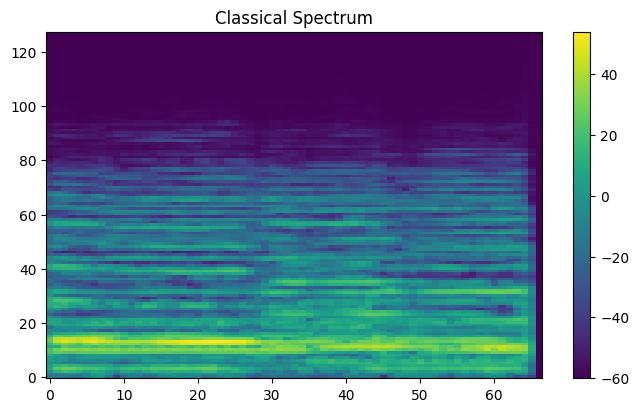

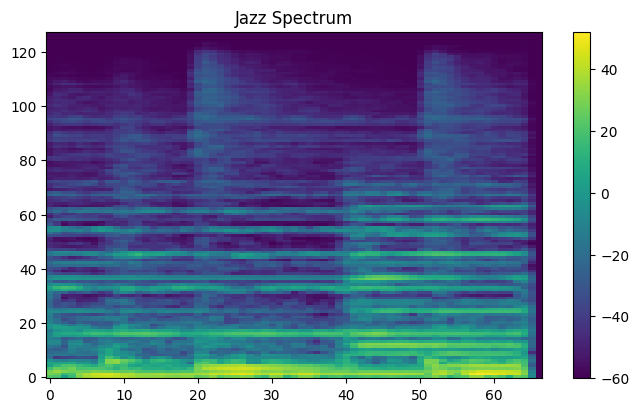

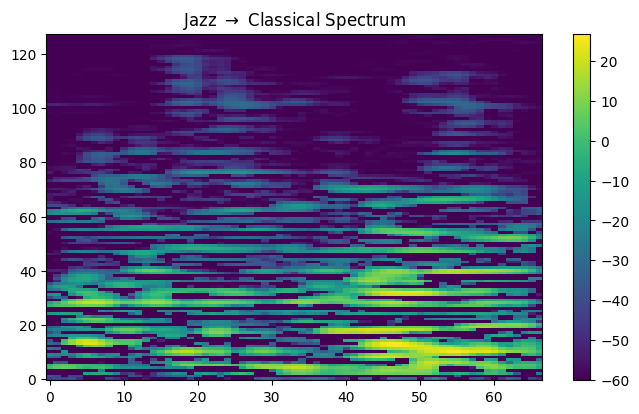

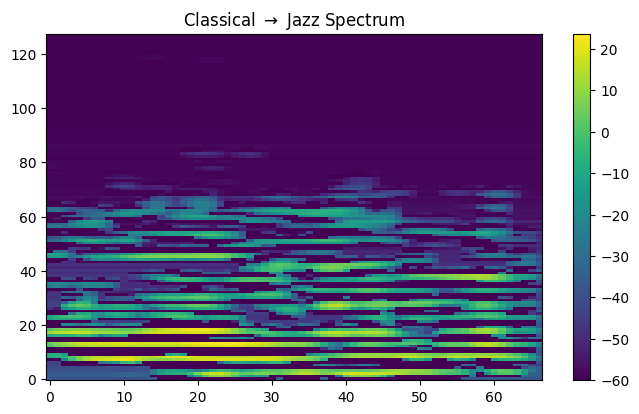

Reconstructing audio
Classical audio


Jazz audio


Jazz to Classical audio


Classical to Jazz audio


In [68]:
# Test transcoder
test_transcoder(transcoder)

In [65]:
# Save transcoder
transcoder.save_weights(os.path.join(results_path, "model"))

In [75]:
# Load transcoder
transcoder = VariationalTranscoder(**default_params)
transcoder.load_weights(os.path.join(results_path, "model"))

### GAN Style Transfer

In [8]:
from models.transcoders import GANTranscoder, GANDiscriminators
from models.layers import GAN

In [9]:
def create_gan_model(**params):
    # Split generator & discriminator params
    g_params = {}
    d_params = {}
    for key, value in params.items():
        if key[:2] == "g_":
            # Generator param
            g_params[key[2:]] = value
        elif key[:2] == "d_":
            # Discriminator param
            d_params[key[2:]] = value
        else:
            # Shared param
            g_params[key] = value
            d_params[key] = value
    generator = GANTranscoder(**g_params)
    discriminator = GANDiscriminators(**d_params)
    gan = GAN(generator, discriminator)
    return gan

In [10]:
default_params = {
    "feature_shape": input_shape,
    "g_compression": 4,
    "g_kernel_size": 5,
    "g_conv_depth": 2,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": False,
    "g_pooling_type": "average",
    "g_gan_reg": 0.02,
    "g_c_reg": 0.01,
    "g_s_reg": 0.05,
    "g_mode": "adain",
    "g_hidden_activation": "relu",
    "g_use_fake_style": True,
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

compile_kwargs={
    "g_optimizer": "adam",
    "d_optimizer": "adam",
}

results_path = os.path.join("./results/GANTranscoder")
os.makedirs(results_path, exist_ok=True)

In [11]:
# Build model
gan = create_gan_model(**default_params)
gan.compile(**compile_kwargs)

2023-11-27 00:34:31.598021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 00:34:31.608587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 00:34:31.611305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
# Train model
loss_key = "val_r_loss"
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = gan.fit(X_c_train, X_j_train, epochs=250, shuffle=True, callbacks=[earlystopping], verbose=1, validation_data=(X_c_val, X_j_val))

Epoch 1/250


2023-11-27 00:34:48.796025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2023-11-27 00:34:51.366993: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd8bac289e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 00:34:51.367029: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-27 00:34:51.372275: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 00:34:51.475127: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 25s 58ms/step - loss: 0.2940 - r_loss: 0.1994 - gan_loss: 2.7158 - c_loss: 0.0145 - s_loss: 0.8013 - d_loss: 0.5151 - val_loss: 0.3041 - val_r_loss: 0.1939 - val_gan_loss: 3.4887 - val_c_loss: 0.0162 - val_s_loss: 0.8047 - val_d_loss: 0.3758
Epoch 2/250
125/125 [==============================] - 5s 36ms/step - loss: 0.2896 - r_loss: 0.1896 - gan_loss: 2.9550 - c_loss: 0.0413 - s_loss: 0.8111 - d_loss: 0.3778 - val_loss: 0.2826 - val_r_loss: 0.1831 - val_gan_loss: 2.8619 - val_c_loss: 0.1411 - val_s_loss: 0.8165 - val_d_loss: 0.2711
Epoch 3/250
125/125 [==============================] - 4s 36ms/step - loss: 0.2667 - r_loss: 0.1730 - gan_loss: 2.5755 - c_loss: 0.1318 - s_loss: 0.8178 - d_loss: 0.4758 - val_loss: 0.2616 - val_r_loss: 0.1623 - val_gan_loss: 2.8549 - val_c_loss: 0.1311 - val_s_loss: 0.8169 - val_d_loss: 0.4399
Epoch 4/250
125/125 [==============================] - 5s 36ms/step - loss: 0.2574 - r_loss: 0.1599 - gan_loss: 2.8068 - c_

Epoch 29/250
125/125 [==============================] - 5s 38ms/step - loss: 0.2299 - r_loss: 0.1162 - gan_loss: 3.5744 - c_loss: 0.1808 - s_loss: 0.8093 - d_loss: 0.1940 - val_loss: 0.2231 - val_r_loss: 0.1131 - val_gan_loss: 3.4064 - val_c_loss: 0.1410 - val_s_loss: 0.8075 - val_d_loss: 0.1917
Epoch 30/250
125/125 [==============================] - 5s 38ms/step - loss: 0.2263 - r_loss: 0.1143 - gan_loss: 3.4903 - c_loss: 0.1593 - s_loss: 0.8130 - d_loss: 0.1851 - val_loss: 0.2247 - val_r_loss: 0.1128 - val_gan_loss: 3.4988 - val_c_loss: 0.1920 - val_s_loss: 0.8015 - val_d_loss: 0.1773
Epoch 31/250
125/125 [==============================] - 5s 38ms/step - loss: 0.2260 - r_loss: 0.1127 - gan_loss: 3.5383 - c_loss: 0.1962 - s_loss: 0.8119 - d_loss: 0.1729 - val_loss: 0.2251 - val_r_loss: 0.1115 - val_gan_loss: 3.5691 - val_c_loss: 0.1829 - val_s_loss: 0.8077 - val_d_loss: 0.1653
Epoch 32/250
125/125 [==============================] - 5s 38ms/step - loss: 0.2243 - r_loss: 0.1129 - gan_lo

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


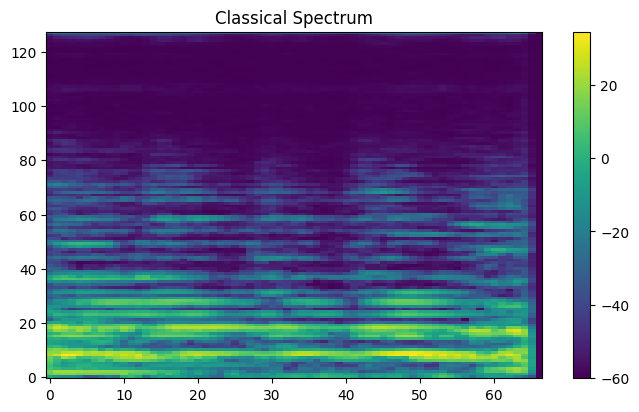

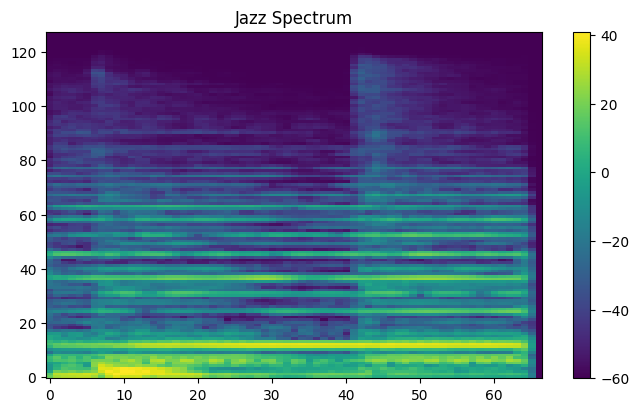

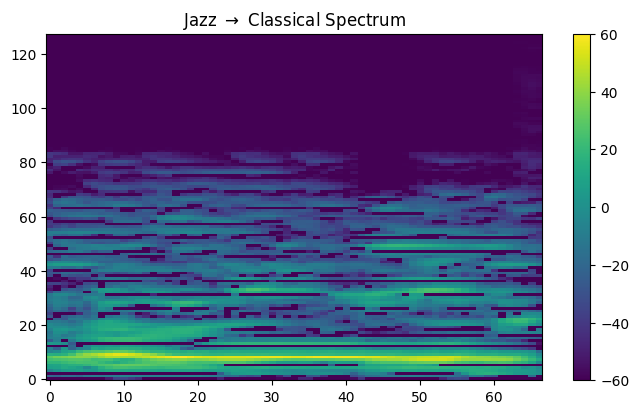

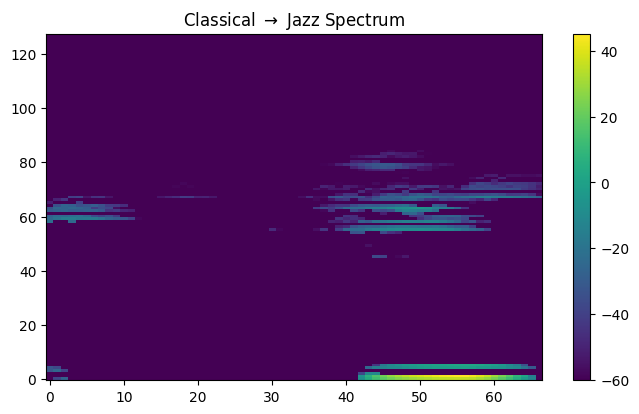

Reconstructing audio
Classical audio


Jazz audio


Jazz to Classical audio


Classical to Jazz audio


In [20]:
# Test model
test_transcoder(gan.generator)

In [ ]:
# Save transcoder
gan.generator.save_weights(os.path.join(results_path, "model"))

In [ ]:
# Load transcoder
gan = create_gan_model(**default_params)
gan.generator.load_weights(os.path.join(results_path, "model"))